# User guide on the expanded Conn2Res package
This example file serves as an introduction to the extensions on the Conn2res package provided by Suárez et al. (2024), which can be downloaded from: github.com/netneurolab/conn2res. Most of the code is adapted from Suárez et al. (2024) to stay consistent with the original implementation. The tutorial runs through the characteristic steps in implementing plasticity and/or conduction delays in the network.

In [1]:
# Import packages for data generation and visualisation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import Conn2res packages
from conn2res.connectivity import Conn
from conn2res import readout

# Import extended Conn2res packages
import RC_lesion as RC
import task_class as tc

## Defining the connectome and task

The first step is to define the connectome. This randomly initialised, or derived from existing connectome data. This example relies on publicly available connectome data (https://zenodo.org/records/10205004). This dataset contains 70 individual human connectomes measured by Griffa et al. (2019), and six group-level consensus connectomes created by Suárez et al.

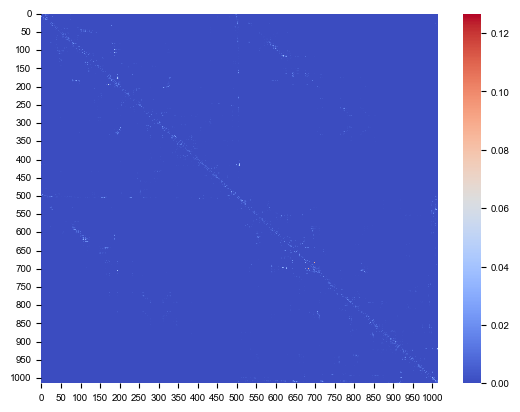

In [2]:
connectome = "data/human/consensus_0.npy"
w = np.load(connectome)

# Use the Conn2Res package to build a reservoir
conn = Conn(w=w)
# Scale by the spectral radius
conn.scale_and_normalize()

# Visualisation of the connectome
hm = sns.heatmap(w, cmap="coolwarm", xticklabels=50, yticklabels=50)
plt.show()

In [3]:
# Define the input and output nodes ; this example is based on the resting state networks defined by Yeo et al.
input_nodes = conn.get_nodes(nodes_from = None, node_set = 'subctx')
output_nodes = conn.get_nodes(nodes_from = None, node_set = 'VIS')

The second step is to define the task. The task should define the input and target output values of the model. This example uses a memory task that is an updated version of the pre-defined memory task in the Conn2res package.

In [4]:
# Define the amplification of the input values
INPUT_GAIN = 1.0

# Define the Memory Capacity task
TASK = tc.MemoryCapacity(n = 6000) # n is the TOTAL number of samples (training + test)
u_train, u_test, y_train, y_test = TASK.fetch_data(input_gain=INPUT_GAIN, train=0.8) # train defines the fraction of the samples used for training

# The input matrix W_in depends on the size of the task
w_in = np.zeros((1, conn.n_nodes)) # this task only has 1 input signal
w_in[:, input_nodes] = np.eye(1)

## The first experiment: no plasticity, no delays

When the default parameters of the new reservoir are used, the original workflow defined by Suárez et al. remains unchanged.

In [5]:
# Define the reservoir
esn = RC.ESNLesion(w=conn.w, activation_function='tanh')

# Define the readout module
readout_module = tc.ReadoutMemory(estimator=readout.select_model(y_train), tau=20)

# Scale the reservoir weights
ALPHA = 1.5 # An appropriate value for ALPHA can be determined in a parameter search
esn.w = ALPHA * conn.w

# Get the reservoir states at the output nodes for the training and test input
rs_train = esn.simulate(ext_input=u_train, w_in=w_in, output_nodes=output_nodes)
rs_test = esn.simulate(ext_input=u_test, w_in=w_in, output_nodes=output_nodes)

# Train the readout layer and get the performance metrics
MC_train, MC_test, e_train, e_test = readout_module.run_task(X=(rs_train, rs_test), y=(y_train, y_test))

This readout module returns the MC for both the training and test data.

In [6]:
print(MC_test)

3.134510904606338


## The second experiment: plasticity without delays

The introduction of plasticity requires additional parameters and an additional training round. The necessary parameters are: the initialisation of the target value ; the learning rate ; the window size. This code runs you through the implementation of plasticity. The mechanism of plasticity is largely based on the implementation of Falandays et al. (2024).

An additional training set is required. This training set is used during unsupervised learning, where the model uses local information to update its target values. 

In [7]:
x_plasticity, _, _, _ = TASK.fetch_data(input_gain=INPUT_GAIN, train=0.8)

In [8]:
# First the model is generated with plasticity = True
# Targets can be kept at the default initialisation of 0.0 or you can choose your own set of values
esn_plasticity = RC.ESNLesion(w=conn.w, activation_function='tanh', plasticity=True, targets = np.repeat(0.0, conn.w.shape[0]), lr=10e-3, window=25)
ALPHA = 1.5
esn_plasticity.w = ALPHA * conn.w

# run the simulation with plasticity - this is the unsupervised learning phase where the targets update
_ = esn_plasticity.simulate(ext_input=x_plasticity, w_in=w_in, output_nodes=output_nodes)

# Use these target values for the actual model
esn = RC.ESNLesion(w=conn.w, activation_function='tanh', targets = esn_plasticity.T)

# Define the readout module
readout_module = tc.ReadoutMemory(estimator=readout.select_model(y_train), tau=20)

# Scale the reservoir weights
esn.w = ALPHA * conn.w

# Get the reservoir states at the output nodes for the training and test input
rs_train = esn.simulate(ext_input=u_train, w_in=w_in, output_nodes=output_nodes)
rs_test = esn.simulate(ext_input=u_test, w_in=w_in, output_nodes=output_nodes)

# Train the readout layer and get the performance metrics
MC_train, MC_test, e_train, e_test = readout_module.run_task(X=(rs_train, rs_test), y=(y_train, y_test))

In [9]:
print(MC_test)

2.8508036457374972


## The third experiment: delays without plasticity

The implementation of delays again asks for an additional parameter: the product of the smallest time step with the conduction velocity in the reservoir. Additionally, one needs to provide the coordinates of the nodes, as the mechanism works with distance based delays. This mechanism is adapted from Iacob & Dambre (2024).

In [10]:
# provide the coordinates
COORDS = np.load('data/human/coords.npy')

# Define the reservoir
esn = RC.ESNLesion(w=conn.w, activation_function='tanh', delay=True, dtv = 25, coords=COORDS)

# Define the readout module
readout_module = tc.ReadoutMemory(estimator=readout.select_model(y_train), tau=20)

# Scale the reservoir weights
ALPHA = 1.5 # An appropriate value for ALPHA can be determined in a parameter search
esn.w = ALPHA * conn.w

# Get the reservoir states at the output nodes for the training and test input
rs_train = esn.simulate(ext_input=u_train, w_in=w_in, output_nodes=output_nodes)
rs_test = esn.simulate(ext_input=u_test, w_in=w_in, output_nodes=output_nodes)

# Train the readout layer and get the performance metrics
MC_train, MC_test, e_train, e_test = readout_module.run_task(X=(rs_train, rs_test), y=(y_train, y_test))

It should be noted that this experiment requires additional computational time and memory. These computational properties scale with the maximal delay in the network.

In [11]:
print('Maximal delay in the network: ', esn.D_max)
print('Memory Capacity: ', MC_test)

Maximal delay in the network:  7
Memory Capacity:  4.400606248343109


## The fourth experiment: delays with plasticity

Both mechanisms can easily be put together in the same fashion as before. During the first training loop, both plasticity and delays are turned on. During the second training loop, only delays are kept on.

In [12]:
# First the model is generated with plasticity = True
# Targets can be kept at the default initialisation of 0.0 or you can choose your own set of values
esn_plasticity = RC.ESNLesion(w=conn.w, activation_function='tanh', plasticity=True, targets = np.repeat(0.0, conn.w.shape[0]), lr=10e-3, window=25, delay=True, dtv = 25, coords=COORDS)
ALPHA = 1.5
esn_plasticity.w = ALPHA * conn.w

# run the simulation with plasticity - this is the unsupervised learning phase where the targets update
_ = esn_plasticity.simulate(ext_input=x_plasticity, w_in=w_in, output_nodes=output_nodes)

# Use these target values for the actual model
esn = RC.ESNLesion(w=conn.w, activation_function='tanh', targets = esn_plasticity.T, delay=True, dtv=25, coords=COORDS)

# Define the readout module
readout_module = tc.ReadoutMemory(estimator=readout.select_model(y_train), tau=20)

# Scale the reservoir weights
esn.w = ALPHA * conn.w

# Get the reservoir states at the output nodes for the training and test input
rs_train = esn.simulate(ext_input=u_train, w_in=w_in, output_nodes=output_nodes)
rs_test = esn.simulate(ext_input=u_test, w_in=w_in, output_nodes=output_nodes)

# Train the readout layer and get the performance metrics
MC_train, MC_test, e_train, e_test = readout_module.run_task(X=(rs_train, rs_test), y=(y_train, y_test))

In [13]:
print(MC_test)

4.459115394786877


## The fifth experiment: lesioning the connectome

One last functionality that was added to the conn2res package is lesioning. In this tool, a lesioned node is defined as a node of which the reservoir state stays zero. In other words the node does not react to incoming activity, and does not transmit activity. The network defined by w remains untouched.

There are two options to lesion nodes. The first is to input the number of nodes you want to lesion. The network will randomly select that number of nodes from the network, while excluding the input and output nodes. Therefore, these are additional parameters to the network.

In [14]:
# Define the reservoir
esn = RC.ESNLesion(w=conn.w, activation_function='tanh', n_lesions=50, input_nodes=input_nodes, output_nodes=output_nodes)

# Define the readout module
readout_module = tc.ReadoutMemory(estimator=readout.select_model(y_train), tau=20)

# Scale the reservoir weights
ALPHA = 1.5 # An appropriate value for ALPHA can be determined in a parameter search
esn.w = ALPHA * conn.w

# Get the reservoir states at the output nodes for the training and test input
rs_train = esn.simulate(ext_input=u_train, w_in=w_in, output_nodes=output_nodes)
rs_test = esn.simulate(ext_input=u_test, w_in=w_in, output_nodes=output_nodes)

# Train the readout layer and get the performance metrics
MC_train, MC_test, e_train, e_test = readout_module.run_task(X=(rs_train, rs_test), y=(y_train, y_test))

In [15]:
print(MC_test)

3.057508317526121


The second option is to list the nodes you want to lesion sepcifically.

In [16]:
# Define the reservoir
esn = RC.ESNLesion(w=conn.w, activation_function='tanh', n_lesions=[14, 36, 625], input_nodes=input_nodes, output_nodes=output_nodes)

# Define the readout module
readout_module = tc.ReadoutMemory(estimator=readout.select_model(y_train), tau=20)

# Scale the reservoir weights
ALPHA = 1.5 # An appropriate value for ALPHA can be determined in a parameter search
esn.w = ALPHA * conn.w

# Get the reservoir states at the output nodes for the training and test input
rs_train = esn.simulate(ext_input=u_train, w_in=w_in, output_nodes=output_nodes)
rs_test = esn.simulate(ext_input=u_test, w_in=w_in, output_nodes=output_nodes)

# Train the readout layer and get the performance metrics
MC_train, MC_test, e_train, e_test = readout_module.run_task(X=(rs_train, rs_test), y=(y_train, y_test))

In [17]:
print(MC_test)

3.1723516769236535


The lesioning tool can again be combined with a network that implements plasticity and/or delays.

### References
[1] Suárez, L. E., Mihalik, A., Milisav, F., Marshall, K., Li, M., Vértes, P. E., Lajoie, G., & Misic, B. (2024). Connectome-based reservoir computing with the conn2res toolbox. Nature Communications, 15(1). https://doi.org/10.1038/s41467-024-44900-4

[2] Griffa, A., Alemán-Gómez, Y., & Hagmann, P. (2019). Structural and functional connectome from 70 young healthy adults [Dataset]. In Zenodo (CERN European Organization for Nuclear Research). https://doi.org/10.5281/zenodo.2872624

[3] Yeo, B. T. T., Krienen, F. M., Sepulcre, J., Sabuncu, M. R., Lashkari, D., Hollinshead, M., Roffman, J. L., Smoller, J. W., Zöllei, L., Polimeni, J. R., Fischl, B., Liu, H., & Buckner, R. L. (2011b). The organization of the human cerebral cortex estimated by intrinsic functional connectivity. Journal of Neurophysiology, 106(3), 1125–1165. https://doi.org/10.1152/jn.00338.2011

[4] Falandays, J.B., Yoshimi, J., Warren, W.H. et al. A potential mechanism for Gibsonian resonance: behavioral entrainment emerges from local homeostasis in an unsupervised reservoir network. Cogn Neurodyn 18, 1811–1834 (2024). https://doi.org/10.1007/s11571-023-09988-2

[5] Iacob, S., & Dambre, J. (2024). Exploiting signal propagation delays to match task memory requirements in reservoir computing. Biomimetics, 9(6), 355. https://doi.org/10.3390/biomimetics9060355